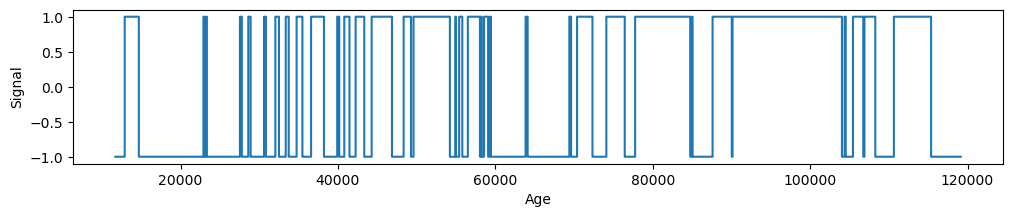

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Given ground truth intervals for the low phase (-1)
gs_data = {
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040,104520,106750,108280,115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380,105440,106900,110640,119140]
}

# Create an age vector (baseline resolution e.g. every 10 years)
ages = np.arange(11703, 119140, 1)

# Initialize signal at +1
signal = np.ones_like(ages)

# Flip to -1 during the specified low-phase intervals
for start, end in zip(gs_data["start"], gs_data["end"]):
    mask = (ages >= start) & (ages <= end)
    signal[mask] = -1

# Build a DataFrame for clarity
df_sq = pd.DataFrame({"age": ages, "sq": signal})

# Plot the irregular square wave
plt.figure(figsize=(12, 2))
plt.step(df_sq["age"], df_sq["sq"], where="post")
plt.xlabel("Age")
plt.ylabel("Signal")
# plt.title("Irregular Square Wave Signal")
plt.show()


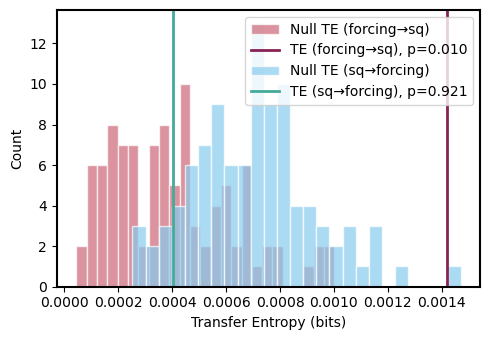

True

In [13]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=4)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')

result

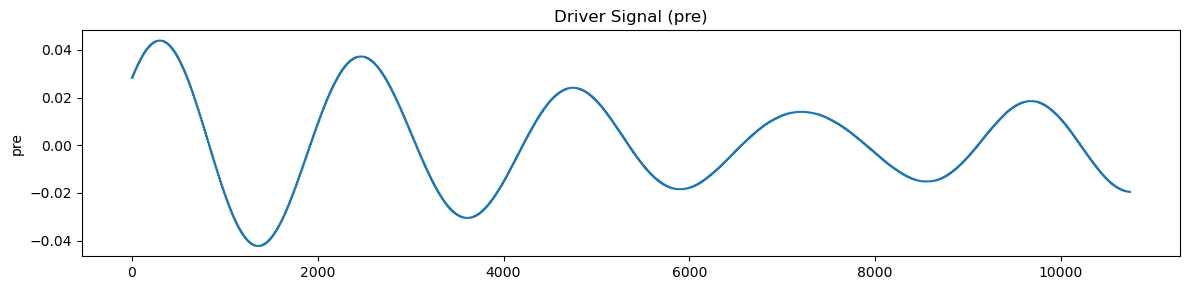

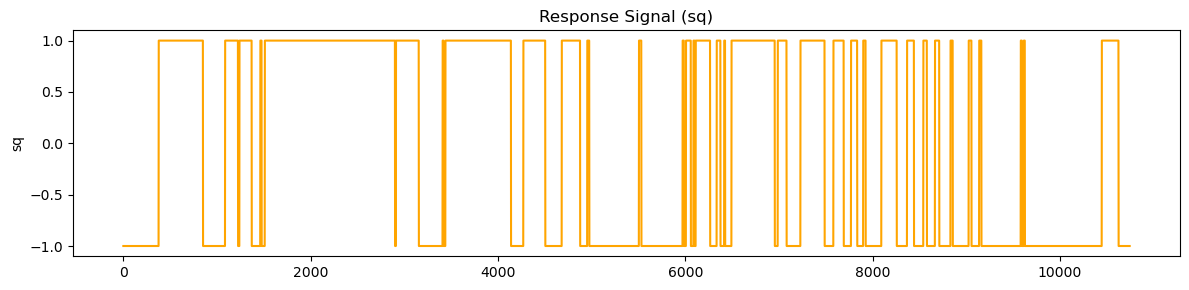

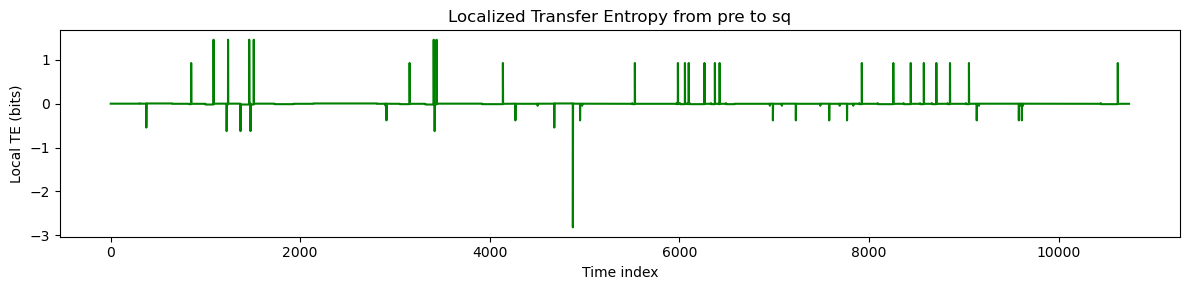

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy

pre_ori = df_pre_i['pre'].values      # source (precession)
sq_ori = df_sq_i['sq'].values    # target (residual)

sq=sq_ori[::-1]
pre=pre_ori[::-1]

# --- 2) Discretization ---
# Pre: 4 bins
nbins_pre = 4
bins_pre = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc = np.digitize(pre, bins_pre) - 1

# SQ: binary mapping (-1 -> 0, +1 -> 1)
sq_disc = (sq > 0).astype(int)

# --- 3) Compute local transfer entropy using PyInform ---
# k=1 lag by default; local=True returns an array of pointwise TE values
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 4) Plot the driver, response, and local TE ---
t = np.arange(len(pre_disc))

plt.figure(figsize=(12, 3))
plt.plot(t, pre, label='pre (raw)')
plt.ylabel('pre')
plt.title('Driver Signal (pre)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(t, sq, label='sq (raw)', color='orange')
plt.ylabel('sq')
plt.title('Response Signal (sq)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(t[1:], local_te.T, label='Local TE', color='green')
plt.xlabel('Time index')
plt.ylabel('Local TE (bits)')
plt.title('Localized Transfer Entropy from pre to sq')
plt.tight_layout()
plt.show()


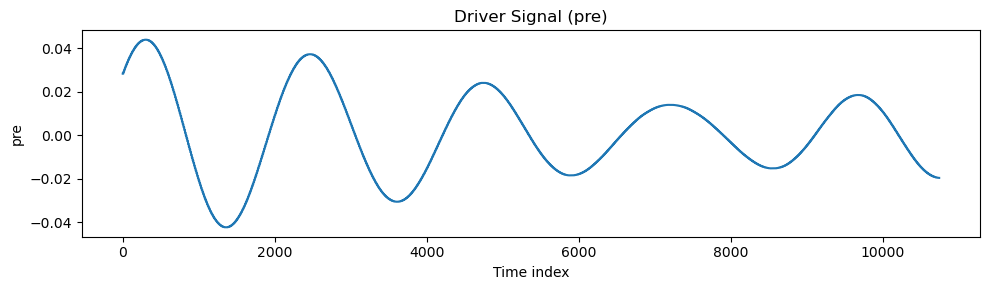

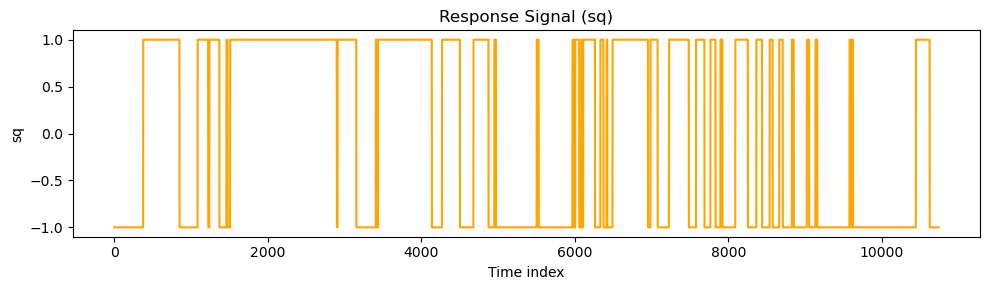

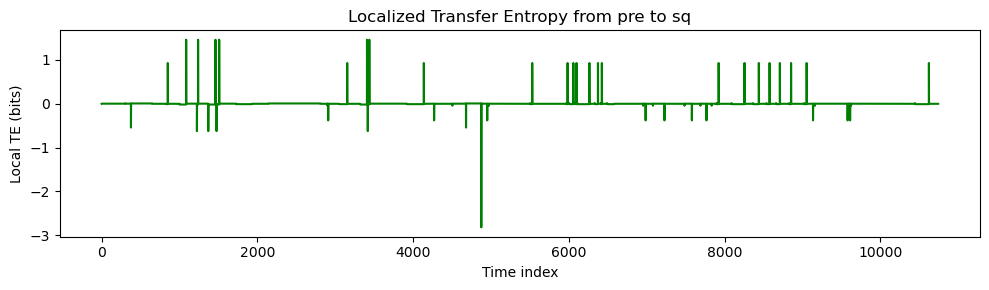

In [26]:
sq.shape
pre.shape

pre_ori = df_pre_i['pre'].values      # source (precession)
sq_ori = df_sq_i['sq'].values    # target (residual)

sq=sq_ori[::-1]
pre=pre_ori[::-1]


import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


# --- 2) Discretization ---
# Pre: 4 bins
nbins_pre = 4
bins_pre = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc = np.digitize(pre, bins_pre) - 1

# SQ: binary (2 bins) mapping -1->0, +1->1
sq_disc = (sq > 0).astype(int)

N = len(pre_disc)

# --- 3) Count frequencies for local TE ---
triplet_counts = Counter()
pair_counts = Counter()

for t in range(1, N):
    y_t    = sq_disc[t]
    y_prev = sq_disc[t - 1]
    x_prev = pre_disc[t - 1]
    triplet_counts[(y_t, y_prev, x_prev)] += 1
    pair_counts[(y_t, y_prev)] += 1

# Denominators for conditional probabilities
denom_triplet = {}
for (y_t, y_prev, x_prev), cnt in triplet_counts.items():
    denom_triplet[(y_prev, x_prev)] = denom_triplet.get((y_prev, x_prev), 0) + cnt

denom_pair = {}
for (y_t, y_prev), cnt in pair_counts.items():
    denom_pair[y_prev] = denom_pair.get(y_prev, 0) + cnt

# --- 4) Compute pointwise (local) transfer entropy ---
local_TE = np.zeros(N)
for t in range(1, N):
    y_t    = sq_disc[t]
    y_prev = sq_disc[t - 1]
    x_prev = pre_disc[t - 1]
    dj = denom_triplet.get((y_prev, x_prev), 0)
    dp = denom_pair.get(y_prev, 0)
    if dj > 0 and dp > 0:
        p_joint_cond = triplet_counts[(y_t, y_prev, x_prev)] / dj
        p_cond       = pair_counts[(y_t, y_prev)] / dp
        if p_cond > 0:
            local_TE[t] = np.log2(p_joint_cond / p_cond)

# --- 5) Plot the results ---
t = np.arange(N)

plt.figure(figsize=(10, 3))
plt.plot(t, pre, label='precession (raw)')
plt.xlabel('Time index')
plt.ylabel('pre')
plt.title('Driver Signal (pre)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, sq, label='sq (raw)', color='orange')
plt.xlabel('Time index')
plt.ylabel('sq')
plt.title('Response Signal (sq)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, local_TE, label='Local TE', color='green')
plt.xlabel('Time index')
plt.ylabel('Local TE (bits)')
plt.title('Localized Transfer Entropy from pre to sq')
plt.tight_layout()
plt.show()





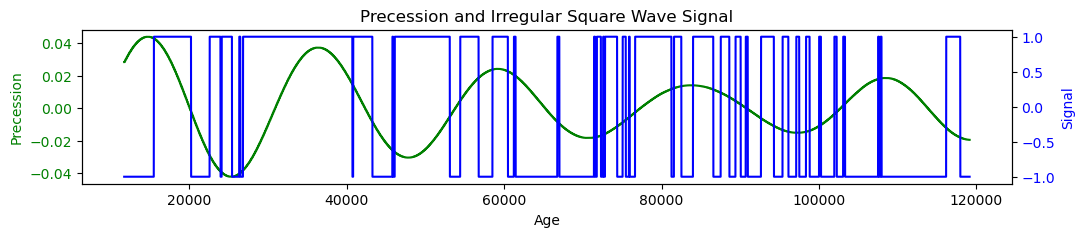

In [4]:
pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)

# flip the two signals upside down
pre = pre[::-1]
sq = sq[::-1]

# plot the two signals using twinx
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 2))
ax2 = ax1.twinx()
ax1.plot(df_pre_i['age'], pre, 'g-')
ax2.plot(df_sq_i['age'], sq, 'b-')
ax1.set_xlabel('Age')
ax1.set_ylabel('Precession', color='g')
ax2.set_ylabel('Signal', color='b')
ax1.tick_params(axis='y', labelcolor='g')
ax2.tick_params(axis='y', labelcolor='b')
plt.title("Precession and Irregular Square Wave Signal")
plt.show()


In [7]:
import numpy as np
from scipy.stats import chi2_contingency


slope_sign = np.diff(pre) < 0  

# define low‐phase by taking the minimum level of your square wave
low_phase = sq.min()
low = (sq[1:] == low_phase)  

# --- 2) build the 2×2 table of counts ---
#           low     not low
# slope↓   [ a ,       b  ]
# slope↑   [ c ,       d  ]
a = np.sum( slope_sign &  low)
b = np.sum( slope_sign & ~low)
c = np.sum(~slope_sign &  low)
d = np.sum(~slope_sign & ~low)

contingency = np.array([[a, b],
                        [c, d]])

# --- 3) conditional probabilities ---
p_low_given_down = a / (a + b)
p_low_given_up   = c / (c + d)

print(f"P(low | pre ↓) = {p_low_given_down:.3f}")
print(f"P(low | pre ↑) = {p_low_given_up:.3f}")

# --- 4) chi‐squared test of independence ---
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f},  p‐value = {p_value}")


P(low | pre ↓) = 0.533
P(low | pre ↑) = 0.488
Chi² = 4.31,  p‐value = 0.037783152027146064


In [9]:
import numpy as np
from scipy.stats import chi2_contingency


slope_sign = np.diff(pre) > 0  

# define low‐phase by taking the minimum level of your square wave
low_phase = sq.min()
low = (sq[1:] == low_phase)  

# --- 2) build the 2×2 table of counts ---
#           low     not low
# slope↓   [ a ,       b  ]
# slope↑   [ c ,       d  ]
a = np.sum( slope_sign &  low)
b = np.sum( slope_sign & ~low)
c = np.sum(~slope_sign &  low)
d = np.sum(~slope_sign & ~low)

contingency = np.array([[a, b],
                        [c, d]])

# --- 3) conditional probabilities ---
p_low_given_down = a / (a + b)
p_low_given_up   = c / (c + d)

print(f"P(low | pre ↓) = {p_low_given_down:.3f}")
print(f"P(low | pre ↑) = {p_low_given_up:.3f}")

# --- 4) chi‐squared test of independence ---
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f},  p‐value = {p_value}")

P(low | pre ↓) = 0.440
P(low | pre ↑) = 0.492
Chi² = 5.09,  p‐value = 0.024031994413653703


In [10]:
import numpy as np
from scipy.stats import chi2_contingency


slope_sign = np.diff(pre) < 0  

# define low‐phase by taking the minimum level of your square wave
high_phase = sq.max()
low = (sq[1:] == high_phase)  

# --- 2) build the 2×2 table of counts ---
#           low     not low
# slope↓   [ a ,       b  ]
# slope↑   [ c ,       d  ]
a = np.sum( slope_sign &  low)
b = np.sum( slope_sign & ~low)
c = np.sum(~slope_sign &  low)
d = np.sum(~slope_sign & ~low)

contingency = np.array([[a, b],
                        [c, d]])

# --- 3) conditional probabilities ---
p_low_given_down = a / (a + b)
p_low_given_up   = c / (c + d)

print(f"P(low | pre ↓) = {p_low_given_down:.3f}")
print(f"P(low | pre ↑) = {p_low_given_up:.3f}")

# --- 4) chi‐squared test of independence ---
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f},  p‐value = {p_value}")

P(low | pre ↓) = 0.467
P(low | pre ↑) = 0.512
Chi² = 4.31,  p‐value = 0.037783152027146064


In [11]:
import numpy as np
from scipy.stats import chi2_contingency


slope_sign = np.diff(pre) > 0  

# define low‐phase by taking the minimum level of your square wave
high_phase = sq.max()
low = (sq[1:] == high_phase)  

# --- 2) build the 2×2 table of counts ---
#           low     not low
# slope↓   [ a ,       b  ]
# slope↑   [ c ,       d  ]
a = np.sum( slope_sign &  low)
b = np.sum( slope_sign & ~low)
c = np.sum(~slope_sign &  low)
d = np.sum(~slope_sign & ~low)

contingency = np.array([[a, b],
                        [c, d]])

# --- 3) conditional probabilities ---
p_low_given_down = a / (a + b)
p_low_given_up   = c / (c + d)

print(f"P(low | pre ↓) = {p_low_given_down:.3f}")
print(f"P(low | pre ↑) = {p_low_given_up:.3f}")

# --- 4) chi‐squared test of independence ---
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f},  p‐value = {p_value}")

P(low | pre ↓) = 0.560
P(low | pre ↑) = 0.508
Chi² = 5.09,  p‐value = 0.024031994413653703


In [5]:
sq.shape

(10744,)

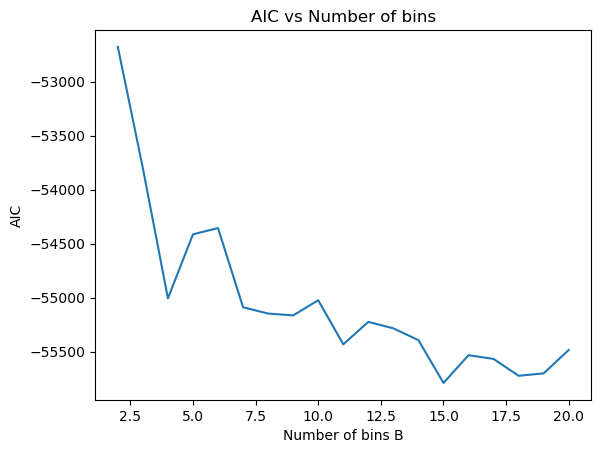

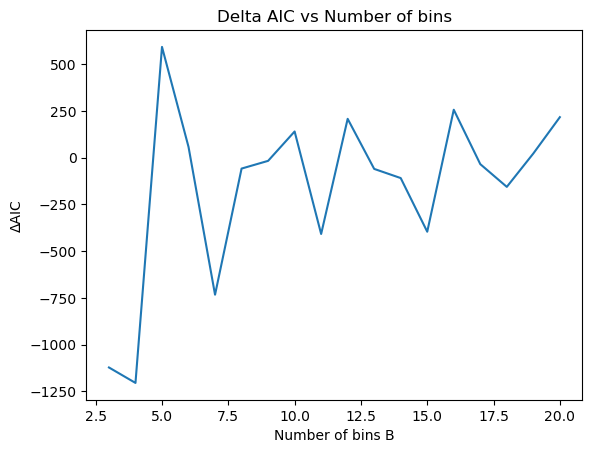

In [18]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

sa.plot_aic_delta(df_pre_i['pre'].values)

In [7]:
pre.shape

(1075,)

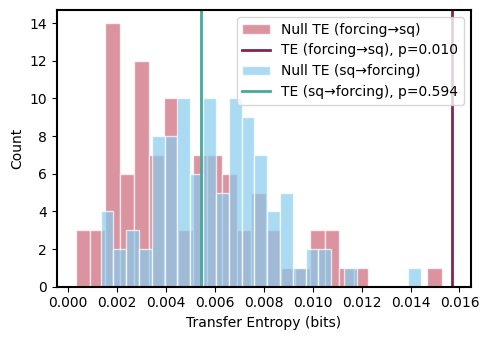

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), interval=100, if_plot=False)

pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq)
result
fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')

# Change in smoothing length

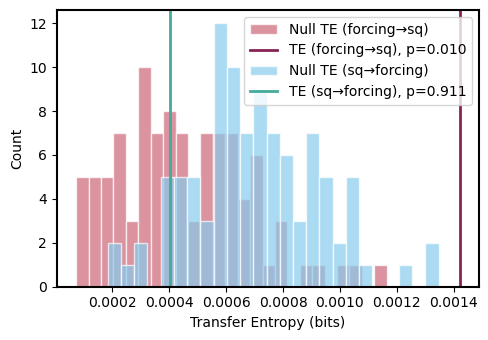

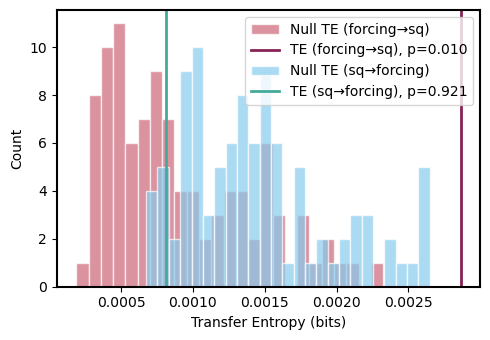

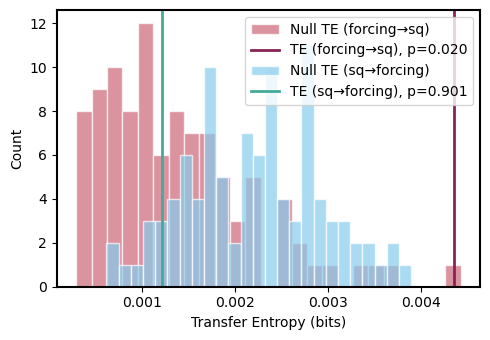

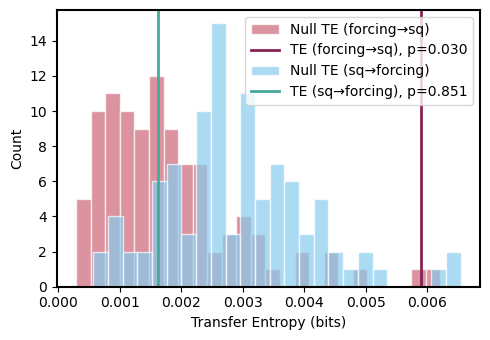

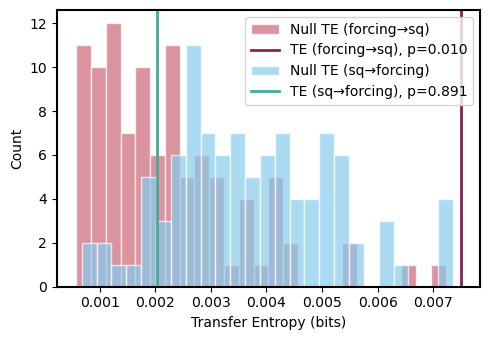

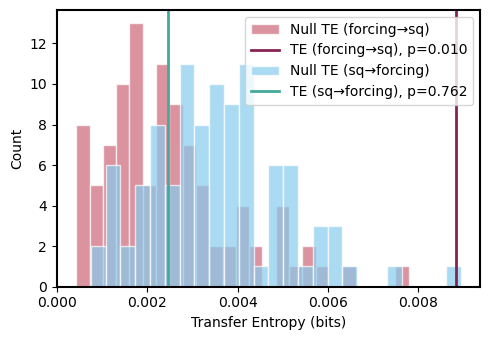

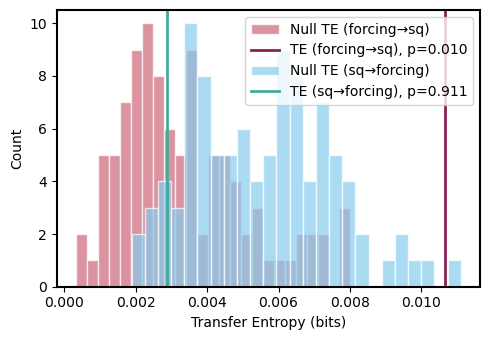

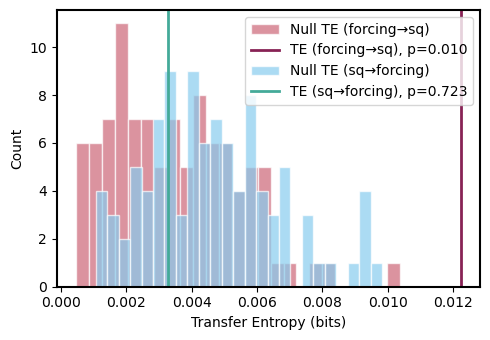

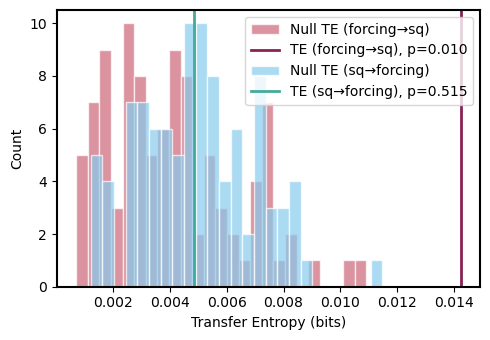

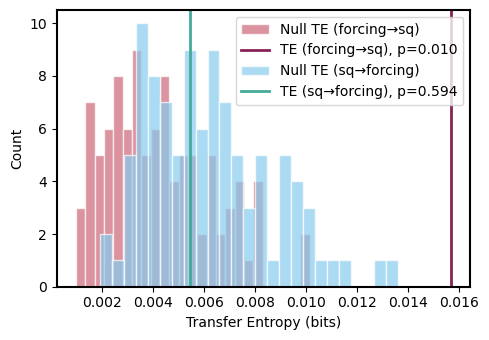

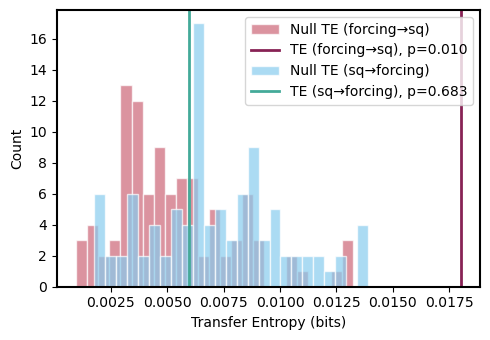

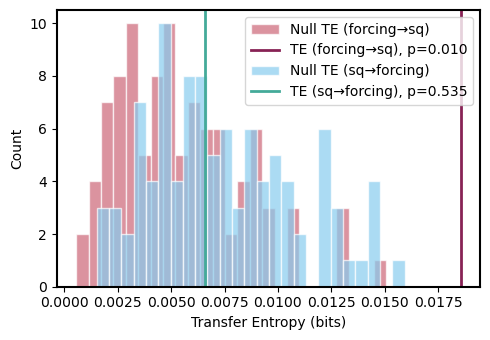

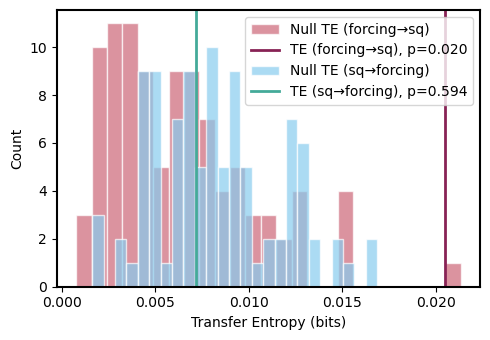

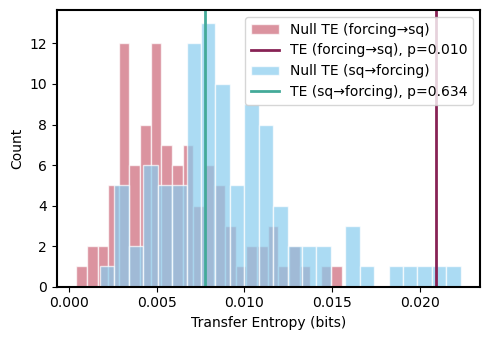

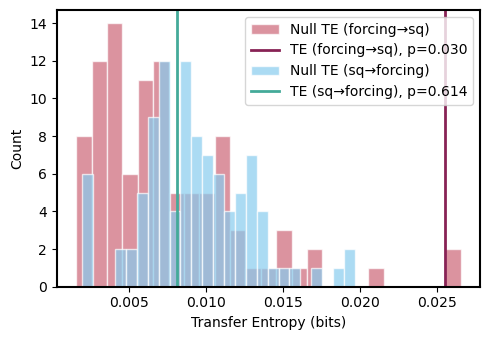

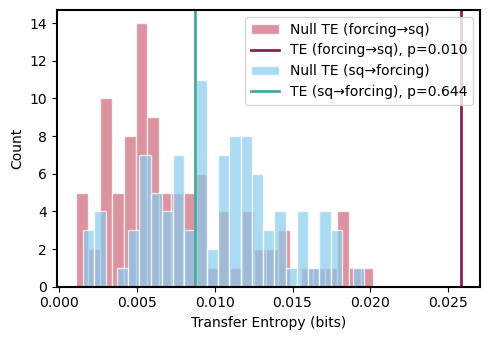

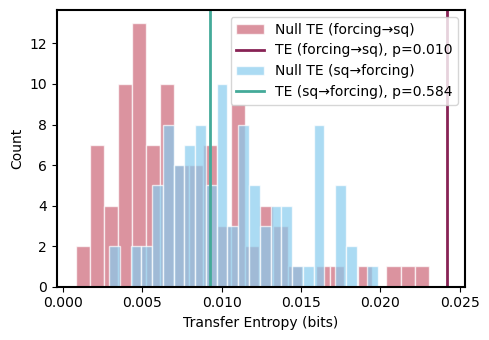

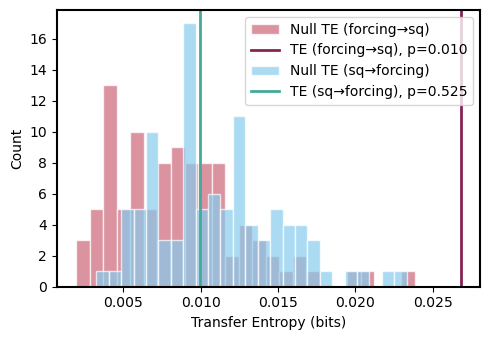

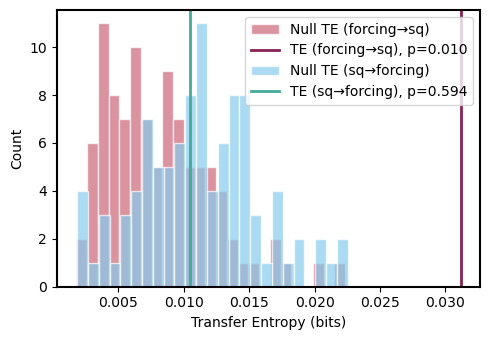

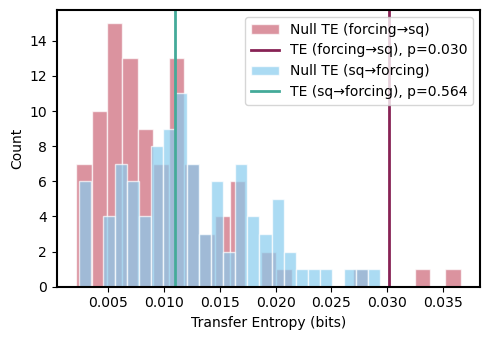

In [21]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

for interval in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]:
    df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), interval=interval, if_plot=False)

    pre = df_pre_i['pre'].values      # source (precession)
    sq = df_sq_i['sq'].values    # target (residual)

    result,fig=sa.transfer_entropy_surrogate_test(pre,sq, k=1, forcing_bins=4)
    result
    # fig.savefig(f'TE_NGRIP_{interval}.pdf',format='pdf',bbox_inches='tight')



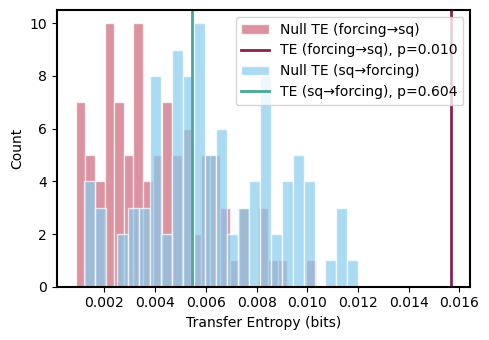

True

In [22]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), interval=100, if_plot=False)

pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, k=1, forcing_bins=4)
result

In [23]:
import numpy as np

for b in (3, 7):
    edges = np.histogram_bin_edges(pre, bins=b)
    counts, _ = np.histogram(pre, bins=edges)
    print(f"forcing_bins={b} → bin counts:", counts)


forcing_bins=3 → bin counts: [287 526 262]
forcing_bins=7 → bin counts: [ 67 119 251 192 257  97  92]


# Changes in lag and bin numbers





MC iters: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


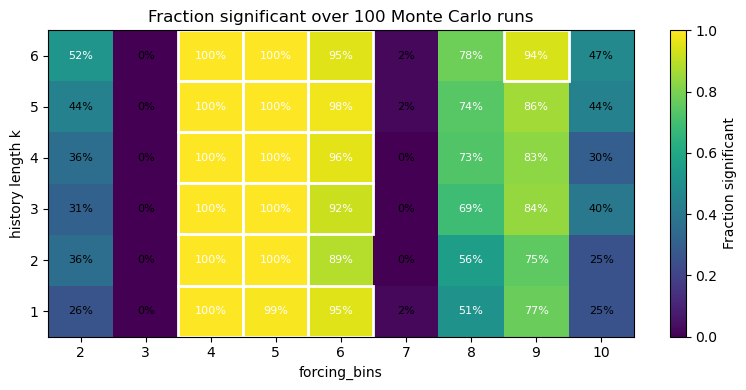

In [6]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)



import numpy as np
import matplotlib.pyplot as plt
from toolbox import sq_ana as sa
import importlib
from joblib import Parallel, delayed
from tqdm import tqdm

# reload in case you tweak the TE function
importlib.reload(sa)

# ── 0) SETTINGS ───────────────────────────────────────────────────────────────
N_JOBS   = -1         # use all cores
niter    = 100        # Monte Carlo reps
n_surr   = 100        # surrogates per TE test
alpha    = 0.05       # p-value threshold
p_thresh = 0.9        # for boxing in the plot

ks    = [1,2,3,4,5,6]  # history lengths
gbins = list(range(2,11))   # 2…10

# ── 1) PREPARE THE DATA ──────────────────────────────────────────────────────
df_sq_i, df_pre_i, _ = sa.interpolate_data_forcing(
    df_sq.copy(),
    interval=10,
    if_plot=False
)
pre = df_pre_i['pre'].values
sq  = df_sq_i['sq'].values

# ── 2) WORKER for one Monte Carlo iteration ─────────────────────────────────
def one_mc_iter(pre, sq, ks, gbins, n_surr, alpha):
    """
    Perform *one* randomization sweep over all (k,forcing_bins) pairs,
    returning a (len(ks),len(gbins)) matrix of 0/1 significance flags.
    """
    local_counts = np.zeros((len(ks), len(gbins)), dtype=int)
    for i, k in enumerate(ks):
        for j, b in enumerate(gbins):
            sig, _ = sa.transfer_entropy_surrogate_test(
                pre, sq,
                k=k,
                forcing_bins=b,
                n_surr=n_surr,
                p=alpha,
                if_plot=False
            )
            local_counts[i,j] = int(sig)
    return local_counts

# ── 3) LAUNCH niter WORKERS IN PARALLEL ────────────────────────────────────
# Each returns a counts‐matrix; we'll sum them all.
results = Parallel(n_jobs=N_JOBS, backend="loky")(
    delayed(one_mc_iter)(pre, sq, ks, gbins, n_surr, alpha)
    for _ in tqdm(range(niter), desc="MC iters")
)

# stack & sum across Monte Carlo reps
total_counts = np.stack(results, axis=0).sum(axis=0)

# fraction significant at each (k,b)
fractions = total_counts / niter

# ── 4) PLOT THE HEATMAP WITH WHITE BOXES & ANNOTATIONS ────────────────────
fig, ax = plt.subplots(figsize=(8,4))

im = ax.imshow(
    fractions,
    origin='lower',
    aspect='auto',
    cmap='viridis',
    vmin=0, vmax=1
)

# axes ticks
ax.set_xticks(np.arange(len(gbins)))
ax.set_xticklabels(gbins)
ax.set_xlabel('forcing_bins')

ax.set_yticks(np.arange(len(ks)))
ax.set_yticklabels(ks)
ax.set_ylabel('history length k')

ax.set_title(f'Fraction significant over {niter} Monte Carlo runs')

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Fraction significant')

# white boxes where fraction > p_thresh
for i, j in zip(*np.where(fractions > p_thresh)):
    rect = plt.Rectangle(
        (j - 0.5, i - 0.5),
        1, 1,
        fill=False,
        edgecolor='white',
        linewidth=2
    )
    ax.add_patch(rect)

# annotate each cell with percentage
for i in range(len(ks)):
    for j in range(len(gbins)):
        pct = fractions[i,j] * 100
        color = 'white' if fractions[i,j] > 0.5 else 'black'
        ax.text(j, i, f"{pct:.0f}%", ha='center', va='center',
                color=color, fontsize=8)

plt.tight_layout()
plt.show()



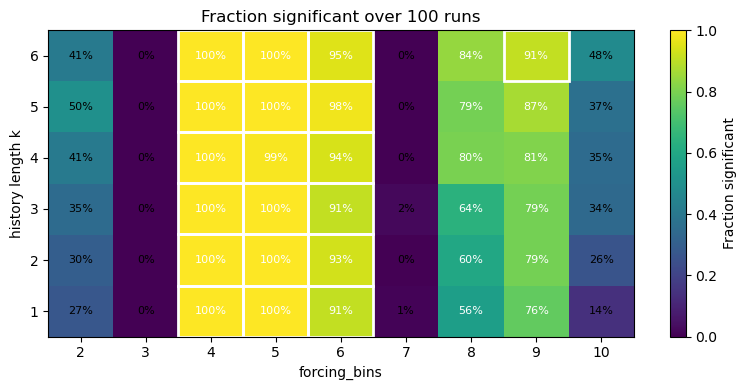

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from toolbox import sq_ana as sa
import importlib

# reload in case you tweak the function
importlib.reload(sa)

# --- 0) settings ---
niter   = 100           # Monte Carlo repetitions
p_thresh = 0.9          # fraction threshold for boxing

# --- 1) prepare your fixed time series once ---
df_sq_i, df_pre_i, _ = sa.interpolate_data_forcing(
    df_sq.copy(),
    interval=10,
    if_plot=False
)
pre = df_pre_i['pre'].values
sq  = df_sq_i['sq'].values

# --- 2) define the parameter grid ---
ks     = [1, 2, 3, 4, 5, 6]
gbins  = list(range(2, 11))   # 2 through 8 inclusive

# matrix to accumulate counts of "significant" outcomes
counts = np.zeros((len(ks), len(gbins)), dtype=int)

# --- 3) Monte Carlo loop ---
for it in range(niter):
    for i, k in enumerate(ks):
        for j, b in enumerate(gbins):
            sig, _ = sa.transfer_entropy_surrogate_test(
                pre, sq,
                k=k,
                forcing_bins=b,
                # leave sq_bins at its default of 2
                n_surr=100,
                p=0.05,
                if_plot=False
            )
            counts[i, j] += int(sig)

# compute the fraction of runs significant
fractions = counts / niter


# --- 4) plot the 2D heatmap of fractions ---
fig, ax = plt.subplots(figsize=(8, 4))

im = ax.imshow(
    fractions,
    origin='lower',        # so k=1 is bottom row
    aspect='auto',
    cmap='viridis',
    vmin=0, vmax=1
)

# ticks & labels
ax.set_xticks(np.arange(len(gbins)))
ax.set_xticklabels(gbins)
ax.set_xlabel('forcing_bins')

ax.set_yticks(np.arange(len(ks)))
ax.set_yticklabels(ks)
ax.set_ylabel('history length k')

ax.set_title(f'Fraction significant over {niter} runs')

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Fraction significant')

# --- outline cells where fraction > p_thresh with white box ---
for i, j in zip(*np.where(fractions > p_thresh)):
    rect = plt.Rectangle(
        (j-0.5, i-0.5),   # (x, y) corner
        width=1, height=1,
        fill=False,
        edgecolor='white',
        linewidth=2
    )
    ax.add_patch(rect)

# --- annotate every cell with percentage ---
for i in range(len(ks)):
    for j in range(len(gbins)):
        pct = fractions[i, j] * 100
        # choose text color for contrast
        txt_color = 'white' if fractions[i, j] > 0.5 else 'black'
        ax.text(
            j, i, f"{pct:.0f}%",
            ha='center', va='center',
            color=txt_color,
            fontsize=8
        )

plt.tight_layout()
plt.show()




# Influence of temporal uncertainty

In [26]:
import numpy as np
from toolbox import sq_ana as sa
import importlib

# reload in case sq_ana changed
importlib.reload(sa)

# your existing preprocessing
max_age_error = 3000
max_age_ratio = max_age_error / np.max(df_sq['age'].values)

df_sq_stretch = df_sq.copy()
df_sq_stretch['age'] = df_sq_stretch['age'].values * max_age_ratio

# single interpolation (we'll reuse these series each iteration)
df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(
    df_sq_stretch.copy(), 10, if_plot=False
)
pre = df_pre_i['pre'].values
sq  = df_sq_i['sq'].values

# now run n_iter repeats of the TE test
n_iter = 100
count_true = 0

for _ in range(n_iter):
    result, _ = sa.transfer_entropy_surrogate_test(
        pre, sq,
        forcing_bins=4,
        if_plot=False
    )
    if result:
        count_true += 1

percent_true = count_true / n_iter * 100
print(f"Result was True in {count_true}/{n_iter} runs ({percent_true:.1f}%)")


Result was True in 96/100 runs (96.0%)


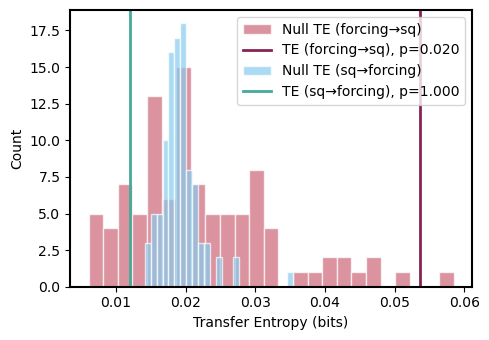

True

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

max_age_error =3000
max_age_ratio = max_age_error/np.max(df_sq['age'].values)

df_sq_stretch = df_sq.copy()
df_sq_stretch['age'] = df_sq_stretch['age'].values * max_age_ratio

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq_stretch.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=4, if_plot=False)


result

In [10]:
np.max(df_sq['age'].values)

119139

# Time varying entropy

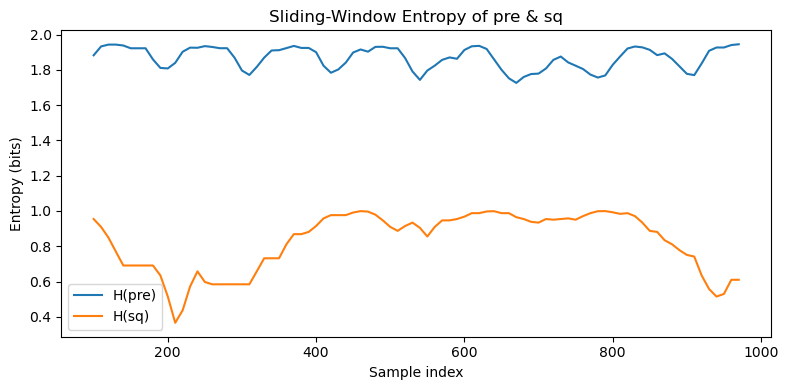

Full-data Transfer Entropy X→Y = 0.014947 bits


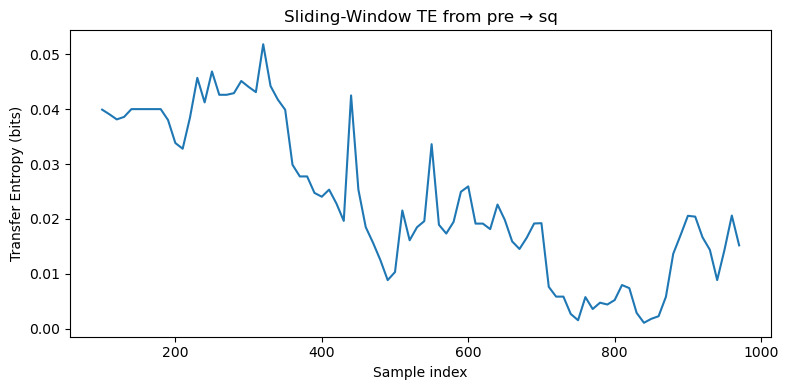

In [ ]:




import numpy as np
import matplotlib.pyplot as plt

pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)
# flip data upside down
pre = pre [::-1]
sq  = sq  [::-1]

# Parameters
window_size = 200           # samples ≃ one period
step_size   = 10            # slide by 10 samples
nbins_pre   = 4            # for entropy of pre
nbins_TE    = 4             # discretization for transfer-entropy
T           = len(pre)

# Time-axis (just sample index or convert to seconds if you know fs)
times = np.arange(T)

# 1) Sliding-window entropy for pre and sq
ent_pre = []
ent_sq  = []
ent_times = []

for start in range(0, T - window_size + 1, step_size):
    w_pre = pre[start:start+window_size]
    w_sq  = sq [start:start+window_size]

    # Shannon entropy of pre (20‐bin histogram)
    counts, _ = np.histogram(w_pre, bins=nbins_pre)
    p = counts / counts.sum()
    p = p[p>0]
    H_pre = -np.sum(p * np.log2(p))

    # Shannon entropy of sq (2‐bin: low vs high)
    counts, _ = np.histogram(w_sq, bins=2)
    p = counts / counts.sum()
    p = p[p>0]
    H_sq = -np.sum(p * np.log2(p))

    ent_pre.append(H_pre)
    ent_sq .append(H_sq)
    ent_times.append(start + window_size//2)

# Plot both entropies on one figure
plt.figure(figsize=(8,4))
plt.plot(ent_times, ent_pre, label='H(pre)')
plt.plot(ent_times, ent_sq,  label='H(sq)')
plt.xlabel('Sample index')
plt.ylabel('Entropy (bits)')
plt.title('Sliding-Window Entropy of pre & sq')
plt.legend()
plt.tight_layout()
plt.show()


# 2) Define a function to compute TE(X→Y) on discretized sequences
def transfer_entropy(x_disc, y_disc, nbins):
    # TE = ∑ p(yₜ₊₁,yₜ,xₜ) · log₂[ p(yₜ₊₁|yₜ,xₜ) / p(yₜ₊₁|yₜ) ]
    T = len(y_disc) - 1
    c_xyz = np.zeros((2,2,nbins))   # yₜ₊₁ ∈ {0,1}, yₜ ∈ {0,1}, xₜ ∈ [0..nbins-1]
    c_yx  = np.zeros((2,nbins))
    c_yy  = np.zeros((2,2))
    c_y   = np.zeros(2)

    for t0 in range(T):
        y1 = y_disc[t0+1]
        y0 = y_disc[t0]
        x0 = x_disc[t0]
        c_xyz[y1,y0,x0] += 1
        c_yx [y0,  x0]   += 1
        c_yy [y1, y0]    += 1
        c_y  [y0]        += 1

    p_xyz = c_xyz / T
    p_yx  = c_yx  / T
    p_yy  = c_yy  / T
    p_y   = c_y   / T

    TE = 0.0
    for y1 in (0,1):
        for y0 in (0,1):
            for x0 in range(nbins):
                pj = p_xyz[y1,y0,x0]
                if pj > 0 and p_yx[y0,x0] > 0 and p_yy[y1,y0] > 0 and p_y[y0] > 0:
                    p1 = pj / p_yx[y0,x0]      # p(yₜ₊₁|yₜ,xₜ)
                    p2 = p_yy[y1,y0] / p_y[y0]  # p(yₜ₊₁|yₜ)
                    TE += pj * np.log2(p1 / p2)
    return TE

# Discretize full sequences
#  - pre → x_disc in [0..nbins_TE-1]
#  - sq  → y_disc ∈ {0,1}
edges = np.linspace(np.min(pre), np.max(pre), nbins_TE+1)
x_full = np.digitize(pre, bins=edges[1:-1])
y_full = (sq > 0).astype(int)

TE_full = transfer_entropy(x_full, y_full, nbins_TE)
print(f"Full-data Transfer Entropy X→Y = {TE_full:.6f} bits")


# 3) Time-varying TE via sliding windows
TE_slide = []
TE_times = []

for start in range(0, T - window_size + 1, step_size):
    xw = x_full[start:start+window_size]
    yw = y_full[start:start+window_size]
    TEw = transfer_entropy(xw, yw, nbins_TE)
    TE_slide.append(TEw)
    TE_times.append(start + window_size//2)

# Plot time-varying TE
plt.figure(figsize=(8,4))
plt.plot(TE_times, TE_slide)
plt.xlabel('Sample index')
plt.ylabel('Transfer Entropy (bits)')
plt.title('Sliding-Window TE from pre → sq')
plt.tight_layout()
plt.show()
